# Baseline model

Split the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
from xverse.feature_subset import SplitXY

def splitXY(df, target_column):

    clf = SplitXY([target_column]) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    return X, y

def make_train_test_split(X=None, y=None, test_size=0.3, random_state=1234):

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
selected_vars = ['V11', 'V12', 'V3', 'V19', 'V7', 'V14', 'V1', 'V4', 'V21', 'V2', 'V18', 'V16', 'V17', 'V9', 'V10']

# Build logistic regression model

In [5]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [6]:
def build_model(X, y):

    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

In [7]:
def evaluate_model(clf, X, y):
    
    pred = clf.predict(X) #predicted classes
    accuracy = accuracy_score(pred,y) # calculate accuracy
    fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1]) # roc_curve
    auc_value = auc(fpr,tpr) # auc_value
    report = classification_report(y, pred, labels=[0,1], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.reset_index()
    model_eval  = report_df[report_df['index'].str.contains('1')][['precision','recall','f1-score']]
    model_eval['accuracy']  = list(report_df[report_df['index'].str.contains('accuracy')]['support'])
    model_eval['ROC']  = auc_value
    cf_matrix = confusion_matrix(y, pred)
    
    return model_eval, cf_matrix

In [8]:
def model_eval_data(clf, X_train, y_train, 
                         X_test, y_test, 
                         model_eval_train, 
                         model_eval_test,
                         Name=None):
    
    temp_eval_train, cf_matrix_train = evaluate_model(clf, X_train, y_train)
    temp_eval_test, cf_matrix_test = evaluate_model(clf, X_test, y_test)
    temp_eval_train.index = [Name]
    temp_eval_test.index = [Name]
    
    try:
        model_eval_train = model_eval_train.append(temp_eval_train)
        model_eval_test = model_eval_test.append(temp_eval_test)
    except:
        model_eval_train = temp_eval_train
        model_eval_test = temp_eval_test
    
    return model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test

In [9]:
def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    plt.figure(1, figsize=(10,5))

    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.title('Train data')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=['Not Fraud', 'Fraud'], 
                                xticklabels=['Not Fraud', 'Fraud'], fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,2])
    plt.tight_layout()
    plt.title('Test data')

    plt.tight_layout()
    return None

In [10]:
model_eval_train = pd.DataFrame({},[])
model_eval_test = pd.DataFrame({},[])

Using imbalanced data

In [11]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=1)

In [12]:
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [13]:
clf = build_model(X_train, y_train)

In [14]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='imbalanced data - LogisticRegression')

In [15]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718


In [16]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.57037,0.681416,0.999157,0.96878


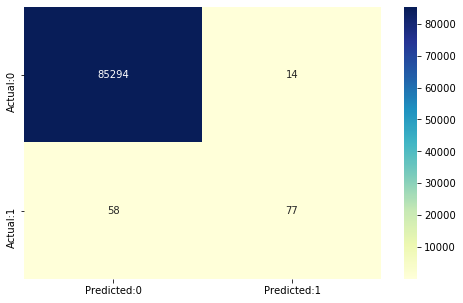

In [17]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.85      0.57      0.68       135

    accuracy                           1.00     85443
   macro avg       0.92      0.79      0.84     85443
weighted avg       1.00      1.00      1.00     85443



Change threshold

In [19]:
from sklearn.preprocessing import binarize

sensitivity_result = []
specifity_result = []
for i in range(0,11):
    cm2=0
    y_pred_prob_yes=clf.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    sensitivity_result.append(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])))
    specifity_result.append(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])))
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
          'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.0 threshold the Confusion Matrix is  
 [[    0 85308]
 [    0   135]] 
 with 135 correct predictions and 0 Type II errors( False Negatives) 

 Sensitivity:  1.0 Specificity:  0.0 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.1 threshold the Confusion Matrix is  
 [[85277    31]
 [   33   102]] 
 with 85379 correct predictions and 33 Type II errors( False Negatives) 

 Sensitivity:  0.7555555555555555 Specificity:  0.9996366108688517 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.2 threshold the Confusion Matrix is  
 [[85283    25]
 [   46    89]] 
 with 85372 correct predictions and 46 Type II errors( False Negatives) 

 Sensitivity:  0.6592592592592592 Specificity:  0.9997069442490739 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.3 threshold the Confusion Matrix is  
 [[85284    24]
 [   51    84]] 
 with 85368 correct predictions and 51 Type II errors( False Negatives) 

 Sensitivity:  0.6222222222222222 Specificity:  0.999718666479111 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.4 threshold the Confusion Matrix is  
 [[85290    18]
 [   56    79]] 
 with 85369 correct predictions and 56 Type II errors( False Negatives) 

 Sensitivity:  0.5851851851851851 Specificity:  0.9997889998593332 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.5 threshold the Confusion Matrix is  
 [[85294    14]
 [   58    77]] 
 with 85371 correct predictions and 58 Type II errors( False Negatives) 

 Sensitivity:  0.5703703703703704 Specificity:  0.9998358887794814 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.6 threshold the Confusion Matrix is  
 [[85295    13]
 [   60    75]] 
 with 85370 correct predictions and 60 Type II errors( False Negatives) 

 Sensitivity:  0.5555555555555556 Specificity:  0.9998476110095185 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.7 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.7 threshold the Confusion Matrix is  
 [[85296    12]
 [   62    73]] 
 with 85369 correct predictions and 62 Type II errors( False Negatives) 

 Sensitivity:  0.5407407407407407 Specificity:  0.9998593332395554 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.8 threshold the Confusion Matrix is  
 [[85296    12]
 [   64    71]] 
 with 85367 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.5259259259259259 Specificity:  0.9998593332395554 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 0.9 threshold the Confusion Matrix is  
 [[85297    11]
 [   74    61]] 
 with 85358 correct predictions and 74 Type II errors( False Negatives) 

 Sensitivity:  0.45185185185185184 Specificity:  0.9998710554695925 





C:\anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=1.0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


With 1.0 threshold the Confusion Matrix is  
 [[85308     0]
 [  135     0]] 
 with 85308 correct predictions and 135 Type II errors( False Negatives) 

 Sensitivity:  0.0 Specificity:  1.0 





Threshold higher,sensitivity lower, specificity higher.

[0.00158    0.76691729 1.        ] [1.         0.75555556 0.        ]
[0.00158    0.78070175 1.        ] [1.         0.65925926 0.        ]
[0.00158    0.77777778 1.        ] [1.         0.62222222 0.        ]
[0.00158    0.81443299 1.        ] [1.         0.58518519 0.        ]
[0.00158    0.84615385 1.        ] [1.         0.57037037 0.        ]
[0.00158    0.85227273 1.        ] [1.         0.55555556 0.        ]
[0.00158    0.85882353 1.        ] [1.         0.54074074 0.        ]
[0.00158    0.85542169 1.        ] [1.         0.52592593 0.        ]
[0.00158    0.84722222 1.        ] [1.         0.45185185 0.        ]


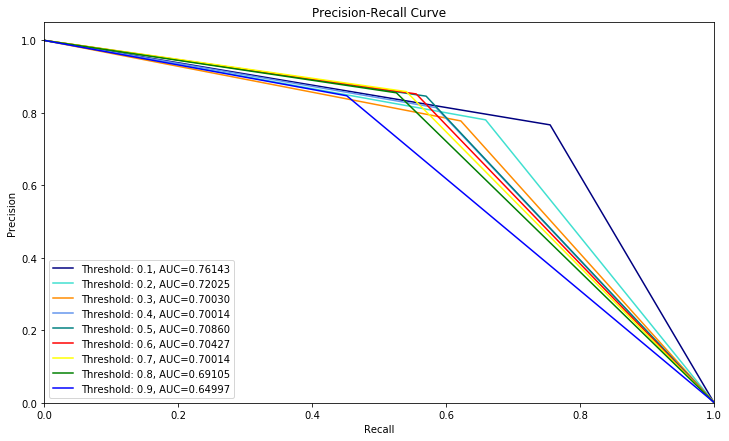

In [20]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_prob_yes[:,1] > i 

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    print(precision, recall)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

Recall metric in the test dataset while threshold=0.1: 0.7555555555555555
Recall metric in the test dataset while threshold=0.2: 0.6592592592592592
Recall metric in the test dataset while threshold=0.3: 0.6222222222222222
Recall metric in the test dataset while threshold=0.4: 0.5851851851851851
Recall metric in the test dataset while threshold=0.5: 0.5703703703703704
Recall metric in the test dataset while threshold=0.6: 0.5555555555555556
Recall metric in the test dataset while threshold=0.7: 0.5407407407407407
Recall metric in the test dataset while threshold=0.8: 0.5259259259259259
Recall metric in the test dataset while threshold=0.9: 0.45185185185185184


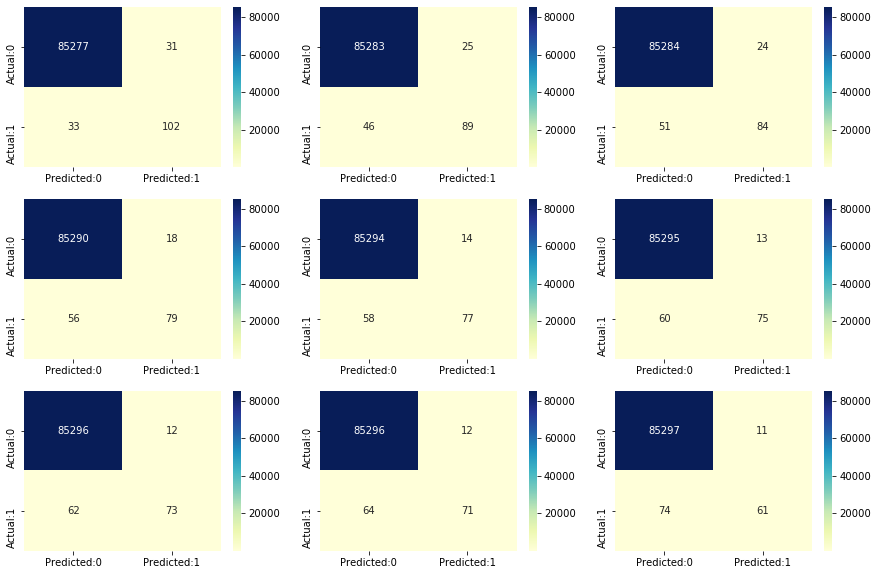

In [21]:
plt.figure(figsize=(15,10))
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
j = 1
for i in thresholds:
    y_test_predictions_prob=y_pred_prob_yes[:,1] > i
    plt.subplot(3,3,j)
    j += 1
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_prob)
    np.set_printoptions(precision=2)
    print('Recall metric in the test dataset while threshold=%s:'%i,cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])) 
    conf_matrix=pd.DataFrame(data=cnf_matrix,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

This is the baseline model using imbalanced data and simple logistic regression.

Then I will use the first sampling techniques on it: Random oversampling

# Smote-logisticregression

In [22]:
from imblearn.over_sampling import SMOTE
#from sklearn.model_selection import GridSearchCV

In [23]:
X, y = splitXY(df, 'Class')
X_train, X_test, y_train, y_test = make_train_test_split(X=X, y=y, test_size=0.3, random_state=0)
X_train = X_train[selected_vars] #select the variables from variable selection proces
X_test = X_test[selected_vars]

In [24]:
smote = SMOTE(random_state=5)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [25]:
clf3 = build_model(X_sm, y_sm)

In [26]:
model_eval_train, model_eval_test, cf_matrix_train, cf_matrix_test = model_eval_data(clf3, X_train, y_train, 
                                                         X_test, y_test, 
                                                         model_eval_train, 
                                                         model_eval_test,
                                                         Name='SMOTE - LogisticRegression')

In [27]:
y_pred = clf3.predict(X_test)

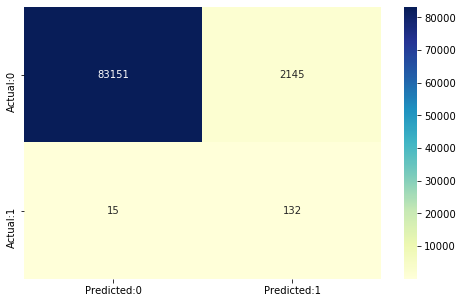

In [28]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

y_pred = clf3.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [29]:
model_eval_train

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.897638,0.638655,0.746318,0.999223,0.974718
SMOTE - LogisticRegression,0.057586,0.904348,0.108277,0.974223,0.980405


In [30]:
model_eval_test

,precision,recall,f1-score,accuracy,ROC
imbalanced data - LogisticRegression,0.846154,0.570370,0.681416,0.999157,0.968780
SMOTE - LogisticRegression,0.057971,0.897959,0.108911,0.974720,0.977955


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1       0.06      0.90      0.11       147

    accuracy                           0.97     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.97      0.99     85443



[0.   0.84 1.  ] [1.   0.77 0.  ]
[0.   0.84 1.  ] [1.  0.7 0. ]
[0.   0.85 1.  ] [1.   0.67 0.  ]
[0.   0.88 1.  ] [1.   0.62 0.  ]
[0.   0.89 1.  ] [1.   0.61 0.  ]
[0.   0.88 1.  ] [1.   0.57 0.  ]
[0.   0.88 1.  ] [1.   0.54 0.  ]
[0.   0.89 1.  ] [1.   0.53 0.  ]
[0.   0.88 1.  ] [1.   0.49 0.  ]


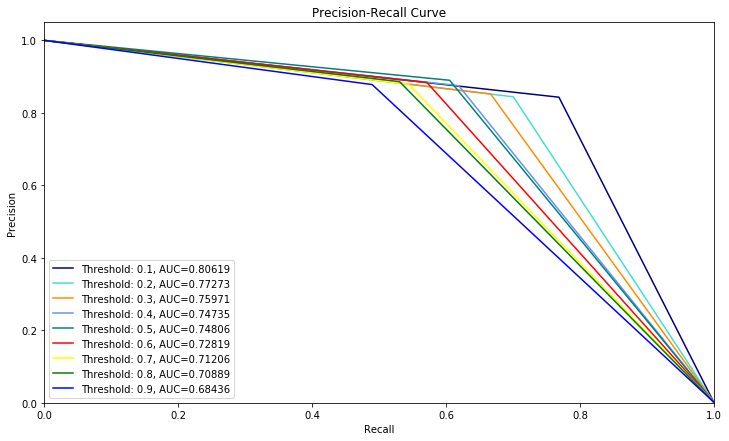

In [33]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])
y_pred_prob_yes=clf.predict_proba(X_test)

plt.figure(figsize=(12,7))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_prob_yes[:,1] > i 

    precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions_prob)
    print(precision, recall)
    area = auc(recall, precision)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s, AUC=%0.5f' %(i , area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")